In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from scipy import interpolate
from scipy import integrate
from scipy.optimize import fsolve
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
import healpy as hp

import os
from os import listdir
from os.path import isfile, join

from multiprocessing import Pool
import time
from numba import njit

import sys
from tqdm import tqdm

In [2]:
href=67 #69
Om0GLOB=0.319
Xi0Glob =1.
clight = 2.99792458* 10**5#km/s
cosmoflag = FlatLambdaCDM(H0=href, Om0=Om0GLOB)
@njit
def E_z(z, H0, Om=Om0GLOB):
    return np.sqrt(Om*(1+z)**3+(1-Om))

def r_z(z, H0, Om=Om0GLOB):
    c = clight
    integrand = lambda x : 1/E_z(x, H0, Om)
    integral, error = integrate.quad(integrand, 0, z)
    return integral*c/H0

def Dl_z(z, H0, Om=Om0GLOB):
    return r_z(z, H0, Om)*(1+z)
def z_dc(dc,h,om=Om0GLOB):
    func = lambda z :r_z(z, href, Om0GLOB) - dc
    zres = fsolve(func, 0.5)[0] 
    return zres
@njit
def phi2RA(phi):
    ret=np.rad2deg(phi)
    return ret
@njit
def theta2DEC(theta):
    ret=np.rad2deg(0.5*np.pi-theta)
    return ret
@njit
def RA2phi(RA):
    ret=np.deg2rad(RA)
    return ret
@njit
def DEC2theta(DEC):
    ret=0.5 * np.pi - np.deg2rad(DEC)
    return ret

In [3]:
#Catalogue path
cat_data_path='/home/rciancarella/DarkSirensStat/data/GLADE/'
os.chdir(cat_data_path)
#all_event=os.listdir()
#print(all_event)
save_cat_path='/home/rciancarella/DarkSirensStat/MyDSStat/'

# Loading The Flagship 

In [4]:
flag = pd.read_csv('GLADE_flagship.txt', sep=" ", header=None)
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
flag.columns=colnames

In [5]:
z_flag_min=flag['z'].min()
z_flag_max=flag['z'].max()
Nobj=flag.shape[0]
dl_flag_min=flag['dl'].min()
dl_flag_max=flag['dl'].max()
RA_flag_min=flag['right_ascension_degrees'].min()
RA_flag_max=flag['right_ascension_degrees'].max()
DEC_flag_min=flag['declination_degrees'].min()
DEC_flag_max=flag['declination_degrees'].max()
phi_flag_min=RA2phi(RA_flag_min)
phi_flag_max=RA2phi(RA_flag_max)
theta_flag_min=DEC2theta(DEC_flag_max)
theta_flag_max=DEC2theta(DEC_flag_min)
print('MotherCat Info:')
print('ref Cosmology={}'.format(cosmoflag))
print('Num of objects={}'.format(Nobj))
print('phi min={}, phi max={}, theta min={}, theta max={}'.format(phi_flag_min,phi_flag_max,theta_flag_min,theta_flag_max))
print('z min={},z max={}'.format(z_flag_min,z_flag_max))
print('dl min={}, dl max={}'.format(dl_flag_min, dl_flag_max))

MotherCat Info:
ref Cosmology=FlatLambdaCDM(H0=67.0 km / (Mpc s), Om0=0.319, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=None)
Num of objects=14047533
phi min=2.719426608367094e-07, phi max=1.5707961936368422, theta min=0.0002976082518162393, theta max=1.5707962750520588
z min=0.7887375950813293,z max=2.01294469833374
dl min=5103.691763013905, dl max=16104.59835705387


In [6]:
delta_phi=phi_flag_max-phi_flag_min
theta_part=np.cos(theta_flag_min)-np.cos(theta_flag_max)
integrand=lambda x:clight*(cosmoflag.comoving_distance(x).value)**2/(cosmoflag.H(x).value)
z_part=integrate.quad(integrand,z_flag_min,z_flag_max)[0]

Volume=delta_phi*theta_part*z_part#integrand
print('Cat Volume {} Gpc^3'.format(Volume/1000**3))
Density=Nobj/Volume
print('Cat Density {} #/Mpc^3'.format(Density))

Cat Volume 67.79817302600848 Gpc^3
Cat Density 0.00020719633543238896 #/Mpc^3


# Evaluating N(z)
chiedere se conviene usare direttamente la flag o la N(z) che mi aveva dato Melita

Text(0, 0.5, '$N(z)$')

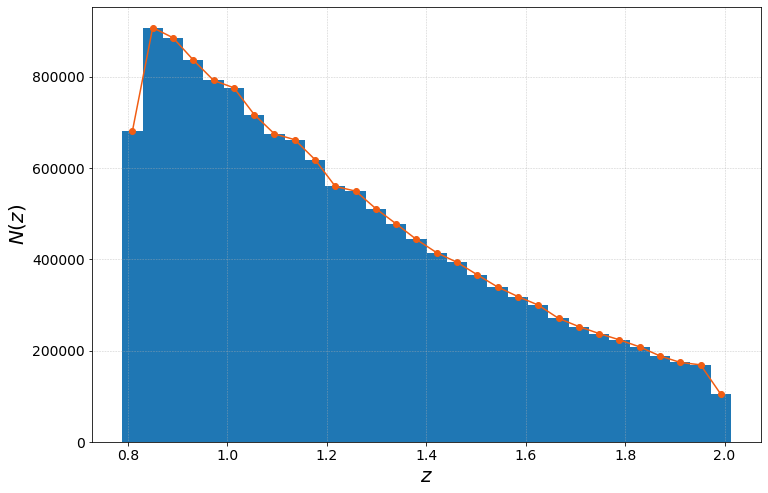

In [7]:
z_flag=np.asarray(flag['z'])
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))


nbins=30
(n, bins, patches)=ax.hist(z_flag,bins=nbins,range=(z_flag_min,z_flag_max))
half_step=(bins[1]-bins[0])/2
mybins=bins[:-1]+half_step
myN=interpolate.interp1d(mybins,n,kind='cubic',fill_value='extrapolate')
ax.scatter(mybins,n,color=colors[3])


ax.plot(mybins,myN(mybins),color=colors[3])
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)

# Make the True Universe
First we need to generate an uniform catalogue in comoving volume. This imply a cosmology. We need a fixed and constant comoving density. The number of object in the most pupulated bin of the data must be the same as the uniform cat

In [20]:
nmax=n.max()
idx=np.where(n==nmax)[0]
zbin_min=bins[idx]
z_bin_max=bins[idx+1]
integrand=lambda x:clight*(cosmoflag.comoving_distance(x).value)**2/(cosmoflag.H(x).value)
z_part=integrate.quad(integrand,zbin_min,z_bin_max)[0]
bin_vol=theta_part*delta_phi*z_part
unif_density=nmax/bin_vol
uniform_numb=int(unif_density*Volume)+1
#-----------------------------------------------------------------------------
dcom_min=cosmoflag.comoving_distance(z_flag_min).value
dcom_max=cosmoflag.comoving_distance(z_flag_max).value
dl_min=cosmoflag.luminosity_distance(z_flag_min).value
dl_max=cosmoflag.luminosity_distance(z_flag_max).value
#-----------------------------------------------------------------------------
print('Catalogue:\nz_min={}, z_max={},\nphi_min={}, phi_max={}, theta_min={}, theta_max={}'
      .format(z_flag_min,z_flag_max,phi_flag_min,phi_flag_max,theta_flag_min,theta_flag_max))


Catalogue:
z_min=0.7887375950813293, z_max=2.01294469833374,
phi_min=2.719426608367094e-07, phi_max=1.5707961936368422, theta_min=0.0002976082518162393, theta_max=1.5707962750520588


In [21]:
cat_name='Uniform_from_flag_big.txt'


#------------------points generator------------------
u = np.random.uniform(0,1,size=uniform_numb) # uniform random vector of size nsamp
dc_gals_all     = np.cbrt((u*dcom_min**3)+((1-u)*dcom_max**3))
phi_gals   = np.random.uniform(phi_flag_min,phi_flag_max,uniform_numb)
theta_gals = np.arccos( np.random.uniform(np.cos(theta_flag_max),np.cos(theta_flag_min),uniform_numb) )
dc_gals=dc_gals_all[dc_gals_all>=dcom_min]
new_phi_gals=np.random.choice(phi_gals,len(dc_gals))
new_theta_gals=np.random.choice(theta_gals,len(dc_gals))


In [ ]:
'''# need to use pool here
    for i in tqdm(range(len(dc_gals))):
        z=z_dc(dc_gals[i],href,Om0GLOB)
        z_gals[i]=z
        dl_gals[i]=Dl_z(z,href,Om0GLOB)
    new_phi_gals=np.random.choice(phi_gals,len(dc_gals))
    new_theta_gals=np.random.choice(theta_gals,len(dc_gals))

    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
    MyCat = pd.DataFrame(columns=colnames)
    MyCat['Ngal']=num
    MyCat['Comoving Distance']=dc_gals
    MyCat['Luminosity Distance']=dl_gals
    MyCat['z']=z_gals
    MyCat['phi']=new_phi_gals
    MyCat['theta']=new_theta_gals
    print('Saving '+cat_name)
    MyCat.to_csv(cat_name, header=None, index=None, sep=' ')'''

In [26]:
def uniform_volume(iterations):
#for i in tqdm(range(flagship.shape[0])):
#for i in range(iterations):
    i=iterations
    numevent=i
    phigal=new_phi_gals[i]
    thetagal=new_theta_gals[i]
    dc=dc_gals[i]
    #----------z----------------------
    zz=z_dc(dc,href,Om0GLOB)
    dl=Dl_z(zz,href,Om0GLOB)
    #----------row to append---------------------
    proxy_row={'Ngal':numevent,'Comoving Distance':dc,'Luminosity Distance':dl,
               'z':zz,'phi':phigal,'theta':thetagal
          }
    return proxy_row
def z_from_dcom(dc_val):
    '''
    Returns redshift for a given comoving distance dc (in Mpc)'''
    
    func = lambda z :cosmoflag.comoving_distance(z).value - dc_val
    z = fsolve(func, 0.5)
    return z[0]

In [27]:
numevent=int(0)
proxy_row={'Ngal':numevent,'Comoving Distance':0,'Luminosity Distance':0,
               'z':0,'phi':0,'theta':0
          }

In [28]:
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
uniform_scaled = pd.DataFrame(columns=colnames)
#glade_like.columns=colnames
uniform_scaled.head()

,Ngal,Comoving Distance,Luminosity Distance,z,phi,theta


In [31]:
from tqdm import tqdm
arr=np.arange(0,len(dc_gals),dtype=int)
data=[]
tmp=[]
start_time = time.time()
print('I am Doing my best, please wait...')
with Pool(14) as p, tqdm(total=len(arr)) as pbar:
    tmp=p.map(uniform_volume, arr)
print("--- %s seconds ---" % (time.time() - start_time))

I am Doing my best, please wait...


  0%|                                                                            | 0/38463771 [01:15<?, ?it/s]Process ForkPoolWorker-40:
Process ForkPoolWorker-39:

Traceback (most recent call last):
Process ForkPoolWorker-37:


KeyboardInterrupt: 

Process ForkPoolWorker-41:
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Process ForkPoolWorker-42:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.10/multiprocessin

  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_361527/3121927838.py", line 10, in uniform_volume
    zz=z_dc(dc,href,Om0GLOB)
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/rciancarella/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py", line 237, in _root_hybr
    retval = _minpack._hybrd(func, x0, args, 1, xtol, maxfev,
  File "/tmp/ipykernel_361527/424105154.py", line 12, in <lambda>
    integrand = lambda x : 1/E_z(x, H0, Om)
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
KeyboardInterrupt
  File "/tmp/ipykernel_361527/3121927838.py", line 10, in uniform_volume
    zz=z_dc(dc,href,Om0GLOB)
  File "/usr/lib/python3.1

  File "/home/rciancarella/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py", line 226, in _root_hybr
    shape, dtype = _check_func('fsolve', 'func', func, x0, args, n, (n,))
  File "/home/rciancarella/.local/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py", line 351, in quad
    retval = _quad(func, a, b, args, full_output, epsabs, epsrel, limit,
  File "/home/rciancarella/.local/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py", line 348, in quad
    flip, a, b = b < a, min(a, b), max(a, b)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/rciancarella/.local/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py", line 463, in _quad
    return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)
  File "/home/rciancarella/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py", line 24, in _check_func
    res = atleast_1d(thefunc(*((x0[:numinputs],) + ar

In [ ]:
uniform_scaled=uniform_scaled.append(tmp, ignore_index=True)

In [ ]:
os.chdir(save_cat_path)
uniform_scaled.to_csv(cat_name, header=None, index=None, sep=' ')

# Plot The results

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

#nbins=30
(n_unif,bin_unif,patches_unif)=ax.hist(uniform_scaled['z'],bins=nbins,range=(z_flag_min,z_flag_max),color=colors[9])
(n_flag,bin_flag,patches_flag)=ax.hist(z_flag,bins=nbins,range=(z_flag_min,z_flag_max),color=colors[-1])

ax.scatter(mybins,n,color=colors[3])
#ax.plot(mybins,myN(mybins),color=colors[3])
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)

In [ ]:
mask=n_flag>n_unif
print(np.sum(mask))

# Statistical Weights $w$(z)

In [ ]:
flag_over_unif=n_flag/n_unif
w_hist=1/flag_over_unif
w=interpolate.interp1d(mybins,w_hist,kind='cubic',fill_value='extrapolate')

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))


nbins=30
ax.plot(mybins,w(mybins),color=colors[3])
#ax.plot(mybins,myN(mybins),color=colors[3])
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$w(z)$', fontsize=20)

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))


nbins=30
ax.plot(mybins,w(mybins)/np.max(w(mybins)),color=colors[-2])
ax.plot(mybins,myN(mybins)/np.max(myN(mybins)),color=colors[3])
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$w(z)$', fontsize=20)

In [ ]:
#np.savetxt('weights_bin.txt', mybins)
#np.savetxt('weights.txt', w(mybins))

# Save the flagship for postcalculator.py

In [ ]:
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
filtered_flag = pd.DataFrame(columns=colnames)
#glade_like.columns=colnames
#filtered_flag.head()

In [ ]:
flag.head(1)

In [ ]:
Ngal=np.arange(flag.shape[0])
dl_to_save=flag['dl'].values
z_to_save=flag['z'].values
dc_to_save=dl_to_save/(1+z_to_save)
phi_to_save=RA2phi(flag['right_ascension_degrees'].values)
theta_to_save=DEC2theta(flag['declination_degrees'].values)

In [ ]:
filtered_flag['Ngal']=Ngal
filtered_flag['Comoving Distance']=dc_to_save
filtered_flag['Luminosity Distance']=dl_to_save
filtered_flag['z']=z_to_save
filtered_flag['phi']=phi_to_save
filtered_flag['theta']=theta_to_save

In [ ]:
filtered_flag.head()
os.chdir(save_cat_path)
filtered_flag.to_csv('Flag.txt', header=None, index=None, sep=' ')

# Extraction from the uniform
Now, for each bin of the data, we thake that many host from the flagship, thus keeping the structure of the catalogue

In [4]:
os.chdir(save_cat_path)

In [8]:
unif = pd.read_csv('Uniform_from_flag_big.txt', sep=" ", header=None)
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
unif.columns=colnames

flag = pd.read_csv('Flag.txt', sep=" ", header=None)
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
flag.columns=colnames

In [9]:
z_flag_min=np.min(flag['z'])
z_flag_max=np.max(flag['z'])


In [10]:
dilution = pd.DataFrame(columns = colnames)
dilution=flag.sample(frac=0.5)

Text(0, 0.5, '$N(z)$')

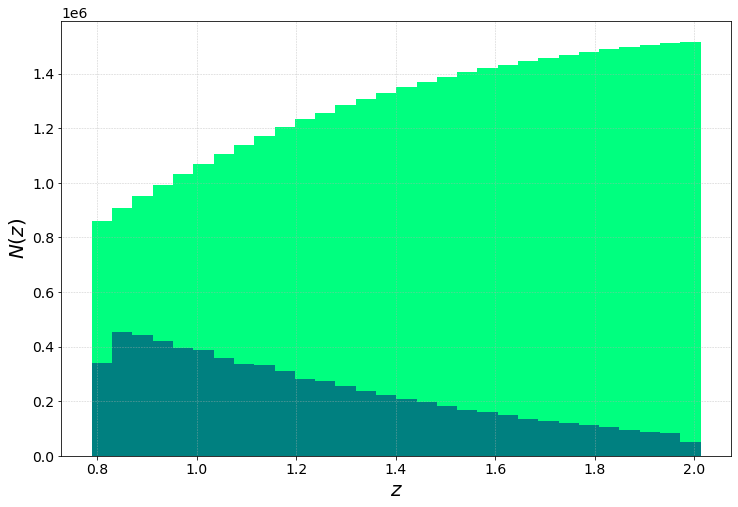

In [26]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

nbins=30

(n_unif,bin_unif,patches_unif)=ax.hist(unif['z'],bins=nbins,range=(z_flag_min,z_flag_max),color='springgreen')
(n_flag,bin_flag,patches_flag)=ax.hist(dilution['z'],bins=nbins,range=(z_flag_min,z_flag_max),color='teal')

#ax.scatter(mybins,n,color=colors[3])
#ax.plot(mybins,myN(mybins),color=colors[3])
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)

In [18]:
mask=n_flag>n_unif
print(np.sum(mask))#if is 0 then ok

0


In [36]:
factor=(n_flag[1]+1000)/n_unif[1]
puppet_unif=unif.sample(frac=factor)

In [39]:
print(factor)

0.5022214570904541


In [37]:
half_step=(bin_unif[1]-bin_unif[0])/2
mybins=bin_unif[:-1]+half_step
n=n_unif-n_flag

In [28]:
result = pd.DataFrame(columns = colnames)

In [29]:
for i in range(len(mybins)):
    temp_bin=unif[unif['z']>=mybins[i]-half_step]
    temp_bin=temp_bin[temp_bin['z']<=mybins[i]+half_step]
    temp_bin=temp_bin.sample(round(n[i]))
    result=result.append(temp_bin, ignore_index=True)

Text(0, 0.5, '$N(z)$')

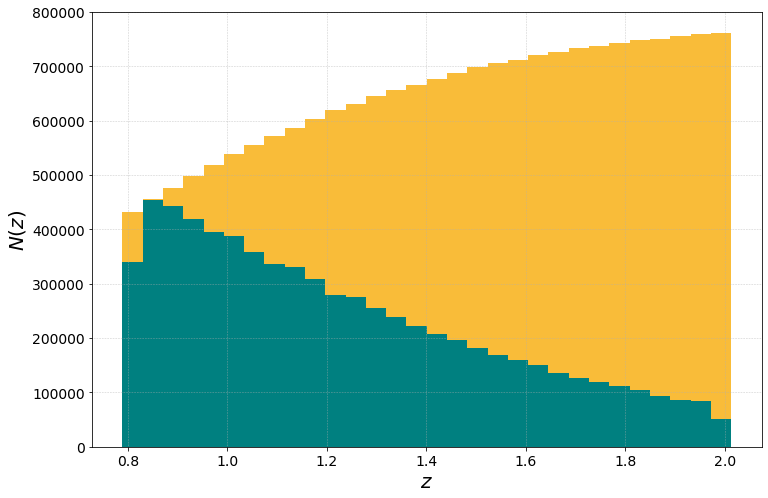

In [41]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

#nbins=30
#(n_unif,bin_unif,patches_unif)=ax.hist(unif['z'],bins=nbins,range=(z_flag_min,z_flag_max),color=colors[9])
(n_puppet,bin_puppet,patches_diluted)=ax.hist(puppet_unif['z'],bins=nbins,range=(z_flag_min,z_flag_max),color=colors[5])
(n_flag,bin_flag,patches_flag)=ax.hist(dilution['z'],bins=nbins,range=(z_flag_min,z_flag_max),color='teal')
#ax.scatter(mybins,n_diluted+n_flag,color='purple',marker='x')
#ax.plot(mybins,myN(mybins),color=colors[3])
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)

In [42]:
mask=n_flag>n_puppet
print(np.sum(mask))

0


In [43]:
os.chdir(save_cat_path)
puppet_unif.to_csv('Uniform_for_half_flag.txt', header=None, index=None, sep=' ')

In [44]:
os.chdir(save_cat_path)
dilution.to_csv('half_flag.txt', header=None, index=None, sep=' ')

In [45]:
flag_over_unif=n_flag/n_puppet
print(np.max(flag_over_unif))
w_hist=1/flag_over_unif
w_normed=w_hist/np.sum(w_hist)
w=interpolate.interp1d(mybins,w_normed,kind='cubic',fill_value='extrapolate')

0.9969307913201549


Text(0, 0.5, '$w(z)$')

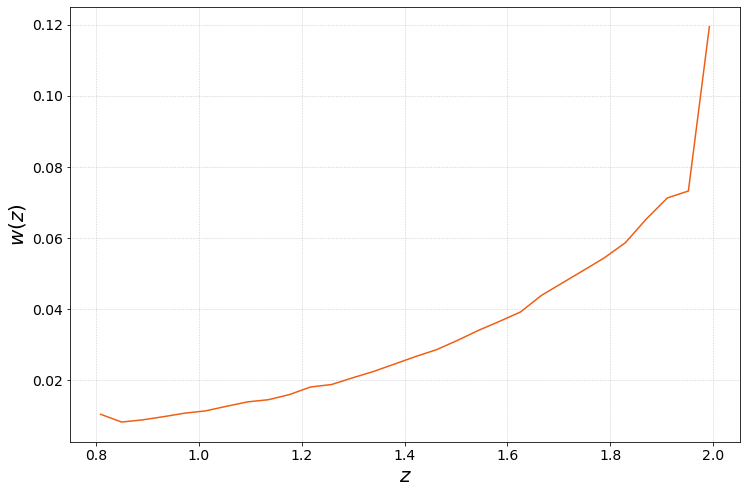

In [46]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))


ax.plot(mybins,w(mybins),color=colors[3])
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$w(z)$', fontsize=20)

In [47]:
np.savetxt('half_flag_bin.txt', mybins)
np.savetxt('half_flag_bin_weights.txt', w_normed)

# Arbitrary N(z)

In [ ]:
from numpy.random import random
#-----------rejection-stuff------------
def sample(g,xmin,xmax):
    x = np.linspace(xmin,xmax,1000000)
    y = g(x)                        # probability density function, pdf
    cdf_y = np.cumsum(y)            # cumulative distribution function, cdf
    cdf_y = cdf_y/cdf_y.max()       # takes care of normalizing cdf to 1.0
    inverse_cdf = interpolate.interp1d(cdf_y,x,fill_value="extrapolate")# this is a function
    #inverse_cdf = np.interp(0,cdf_y,x) #this works but it is not a function
    return inverse_cdf
def return_samples(f,xmin,xmax,N=1000000):
    # let's generate some samples according to the chosen pdf, f(x)
    uniform_samples = random(int(N))       
    required_samples = sample(f,xmin,xmax)(uniform_samples)
    return required_samples

In [ ]:
os.chdir(save_cat_path)
fastcat = pd.read_csv('FullExplorer_big.txt', sep=" ", header=None)
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
fastcat.columns=colnames

In [ ]:
fastcat_zmin=np.min(fastcat['z'])
fastcat_zmax=np.max(fastcat['z'])
nbins=50

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

#nbins=30

(n_unif,bin_unif,patches_unif)=ax.hist(fastcat['z'],bins=nbins,range=(fastcat_zmin,fastcat_zmax),color=colors[9])

#ax.plot(mybins,myN(mybins),color=colors[3])
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)

In [ ]:
#z_cut=0.8
#fast_cutted=fastcat[fastcat['z']>=z_cut]
fast_cutted=fastcat
fast_cutted_zmin=np.min(fast_cutted['z'])
fast_cutted_zmax=np.max(fast_cutted['z'])

nbins=30

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

#nbins=30

(n_unif,bin_unif,patches_unif)=ax.hist(fast_cutted['z'],bins=nbins,range=(fast_cutted_zmin,fast_cutted_zmax),color=colors[9])

#ax.plot(mybins,myN(mybins),color=colors[3])
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)

In [ ]:
print(fast_cutted.shape[0]/1000000)

In [ ]:
zpicco=1.1
alpha=2
gamma=1
beta=1.82#gamma*(alpha/zpicco)
check=(alpha*gamma)/beta
print(alpha,beta,gamma,check)

In [ ]:
#fake_nz=lambda x: 1/x**2
fake_nz=lambda x: (x**alpha)*np.exp(-((x**beta)/gamma))
deriv=lambda x: (x**(alpha-1))*np.exp(-((x**beta)/gamma))*(alpha-beta*x**(beta)/gamma)
N_extraction=1000_000
z_genrated=return_samples(fake_nz,fast_cutted_zmin,fast_cutted_zmax,N_extraction)

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

nbins=50

(n_unif,bin_unif,patches_unif)=ax.hist(fast_cutted['z'],bins=nbins,range=(fast_cutted_zmin,fast_cutted_zmax),
                                       color=colors[9],alpha=0.8)
(n_sel,bin_sel,patches_sel)=ax.hist(z_genrated,bins=nbins,range=(fast_cutted_zmin,fast_cutted_zmax),
                                    color=colors[1],alpha=0.5)

#ax.plot(mybins,myN(mybins),color=colors[3])
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)

In [ ]:
mask=n_sel>n_unif
print(np.sum(mask))#if is 0 then ok

In [ ]:
testdiluted = pd.DataFrame(columns = colnames)
half_step=(bin_unif[1]-bin_unif[0])/2
mybins=bin_unif[:-1]+half_step
for i in range(len(mybins)):
    temp_bin=fast_cutted[fast_cutted['z']>=mybins[i]-half_step]
    temp_bin=temp_bin[temp_bin['z']<=mybins[i]+half_step]
    temp_bin=temp_bin.sample(round(n_sel[i]))
    testdiluted=testdiluted.append(temp_bin, ignore_index=True)

In [ ]:
testdiluted.head()

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

#nbins=30

(n_unif,bin_unif,patches_unif)=ax.hist(fast_cutted['z'],bins=nbins,range=(fast_cutted_zmin,fast_cutted_zmax),color=colors[9])
(n_sel,bin_sel,patches_sel)=ax.hist(testdiluted['z'],bins=nbins,range=(fast_cutted_zmin,fast_cutted_zmax),color=colors[3])

ax.scatter(mybins,n_sel,color=colors[1])
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)

In [ ]:
os.chdir(save_cat_path)
testdiluted.to_csv('Nz01.txt', header=None, index=None, sep=' ')
#fast_cutted.to_csv('CuttedFast.txt', header=None, index=None, sep=' ')

In [ ]:
flag_over_unif=n_sel/n_unif
print(np.max(flag_over_unif))
normed_ratio=flag_over_unif/np.sum(flag_over_unif)
w_hist=1/flag_over_unif
w_normed=w_hist/np.sum(w_hist)
w=interpolate.interp1d(mybins,w_normed,kind='cubic',fill_value='extrapolate')
nn=interpolate.interp1d(mybins,normed_ratio,kind='cubic',fill_value='extrapolate')
#dd=interpolate.interp1d(mybins,dd,kind='cubic',fill_value='extrapolate')

In [ ]:
np.savetxt('Nz01_bin.txt', mybins)
np.savetxt('Nz01_weights.txt', w_normed)

In [ ]:
# Test reverse 

In [ ]:
f=1/w_hist
print(len(mybins))

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

#nbins=30

(n_unif,bin_unif,patches_unif)=ax.hist(fast_cutted['z'],bins=nbins,range=(fast_cutted_zmin,fast_cutted_zmax),color=colors[9])

#ax.plot(mybins,myN(mybins),color=colors[3])
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)

In [ ]:
testpesi= pd.DataFrame(columns = colnames)

In [ ]:
for i in range(len(mybins)):
    temp_bin=fast_cutted[fast_cutted['z']>=mybins[i]-half_step]
    temp_bin=temp_bin[temp_bin['z']<=mybins[i]+half_step]
    temp_bin=temp_bin.sample(round(n_unif[i]*rapporto[i]))
    testpesi=testpesi.append(temp_bin, ignore_index=True)

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

nbins=30

(n_unif,bin_unif,patches_unif)=ax.hist(fast_cutted['z'],bins=nbins,range=(fast_cutted_zmin,fast_cutted_zmax),color=colors[9])
(n_test,bin_test,patches_test)=ax.hist(testpesi['z'],bins=nbins,range=(fast_cutted_zmin,fast_cutted_zmax),color=colors[3])

#ax.scatter(mybins,n_sel,color='purple')

#ax.set_xlabel(r'$z$', fontsize=20)
#ax.set_ylabel(r'$N(z)$', fontsize=20)

In [ ]:
passo=(bin_unif[1]-bin_unif[0])/2
f=interpolate.interp1d(bin_unif[:-1]+passo,n_test/n_unif,kind='linear',fill_value='extrapolate')

In [ ]:
N_zpesi=f(fast_cutted['z'])
#zfortest=np.linspace(0.05,2.5,N_extraction)

In [ ]:
print(N_zpesi[0:30])

In [ ]:
u_mc = np.random.uniform(0,1,size=len(fast_cutted['z']))
mask=N_zpesi>=u_mc

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

#nbins=30

(n_mask,bin_mask,patches_mask)=ax.hist(fast_cutted['z'],bins=nbins,range=(fast_cutted_zmin,fast_cutted_zmax),
                                       color=colors[9],weights=N_zpesi,density=True)
#(n_test,bin_test,patches_test)=ax.hist(z_genrated,bins=nbins,
#                                       range=(fast_cutted_zmin,fast_cutted_zmax),
#                                       color=colors[3])
ax.plot(zfortest,fake_nz(zfortest)/np.trapz(fake_nz(zfortest),zfortest),color='purple',lw=4)
#ax.scatter(allz,N_zpesi,color='purple')
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

#nbins=30

(n_mask,bin_mask,patches_mask)=ax.hist(fast_cutted['z'][mask],bins=nbins,range=(fast_cutted_zmin,fast_cutted_zmax),
                                       color=colors[9],density=True,edgecolor = 'black',
                                       ls='--',lw=1.5,fc=(1, 1, 1, 1))
(n_check,bin_check,patches_check)=ax.hist(testpesi['z'],bins=nbins,
                                       range=(fast_cutted_zmin,fast_cutted_zmax),
                                       color=colors[3],density=True,alpha=0.8)
#ax.plot(zfortest,fake_nz(zfortest)/np.trapz(fake_nz(zfortest),zfortest),color='purple',lw=4)
#ax.scatter(allz,N_zpesi,color='purple')
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)

# Test Robustezza------ Sezione 1

In [ ]:
os.chdir(save_cat_path)
fastcat = pd.read_csv('FullExplorer_big.txt', sep=" ", header=None)
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
fastcat.columns=colnames
zinf=np.min(fastcat['z'])
zsup=np.max(fastcat['z'])

In [ ]:
zmin_cut=0.3
zmax_cut=1.6
fast_cutted=fastcat[fastcat['z']>=zmin_cut]
fast_cutted=fast_cutted[fast_cutted['z']<=zmax_cut]
fast_cutted_zmin=np.min(fast_cutted['z'])
fast_cutted_zmax=np.max(fast_cutted['z'])
nbins=70

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

#nbins=30
(n_mother,bin_mother,patches_mother)=ax.hist(fastcat['z'],bins=nbins,range=(zinf,zsup),color=colors[9])
(n_cut,bin_cut,patches_cut)=ax.hist(fast_cutted['z'],bins=nbins,range=(zinf,zsup),color=colors[2])

#ax.plot(mybins,myN(mybins),color=colors[3])
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)

In [ ]:
os.chdir(save_cat_path)
fast_cutted.to_csv('HostFullCut02.txt', header=None, index=None, sep=' ')

# Scatteirng for all the hosts

In [ ]:
os.chdir(save_cat_path)
fastcat = pd.read_csv('FullExplorer_big_presca.txt', sep=" ", header=None)
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
fastcat.columns=colnames

In [ ]:
dlsigma=0.1

In [ ]:
ds_dl=np.asarray(fastcat['Luminosity Distance'])
sca= np.random.normal(loc=ds_dl, scale=ds_dl*dlsigma, size=None)#scattered[i]#
fastcat['scattered DL']=sca
fastcat.to_csv('FullExplorer_big.txt', header=None, index=None, sep=' ')

# N(DL)

In [ ]:
href=67
dlmax=10_000
dlmin=400
from numpy.random import random
#-----------rejection-stuff------------
def sample(g,xmin,xmax):
    x = np.linspace(xmin,xmax,1000000)
    y = g(x)                        # probability density function, pdf
    cdf_y = np.cumsum(y)            # cumulative distribution function, cdf
    cdf_y = cdf_y/cdf_y.max()       # -takes care of normalizing cdf to 1.0
    inverse_cdf = interpolate.interp1d(cdf_y,x,fill_value="extrapolate")# this is a function
    #inverse_cdf = np.interp(0,cdf_y,x) #this works but it is not a function
    return inverse_cdf
def return_samples(f,xmin,xmax,N=1000000):
    # let's generate some samples according to the chosen pdf, f(x)
    uniform_samples = random(int(N))       
    required_samples = sample(f,xmin,xmax)(uniform_samples)
    return required_samples

In [ ]:
os.chdir(save_cat_path)
fastcat = pd.read_csv('FullExplorer_big.txt', sep=" ", header=None)
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
fastcat.columns=colnames

In [ ]:
path='/home/rciancarella/DarkSirensStat/MyDSStat/results'
source_folder='CatDS'
data_path=os.path.join(path,source_folder)
DSsample=fastcat[fastcat['scattered DL']<=dlmax]
DSsample=DSsample[DSsample['scattered DL']>=dlmin]

DSsample.shape[0]

In [ ]:
save_DS_path='/home/rciancarella/DarkSirensStat/MyDSStat/results/DScat-extracted/'
os.chdir(data_path)
DSsample.to_csv('DScat.txt',header=None, index=None, sep=' ')

In [ ]:
nbins=30
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))


scatter_dlmin=DSsample['scattered DL'].min()
scatter_dlmax=DSsample['scattered DL'].max()
print(scatter_dlmax)
(n_start,bin_start,patches_start)=ax.hist(DSsample['scattered DL'],bins=nbins,
                                          range=(dlmin,dlmax),color=colors[9])
ax.set_xlabel(r'$dl$', fontsize=20)
ax.set_ylabel(r'$N(dl)$', fontsize=20)


In [ ]:
scatter_dlmed=(dlmax-dlmin)/2 +dlmin#scatter_dlmin+(scatter_dlmax-scatter_dlmin)/2
sigma=scatter_dlmed*0.22
alpha=2
beta=2
print(alpha,beta,xp,alpha*xp**beta)
x=np.linspace(dlmin,dlmax,1000)
roof=1/(dlmax-dlmin)
UnifPdet=lambda x: x*0+1/(dlmax-dlmin)
#mydist= lambda x: np.heaviside(dlmed-x,1)*0.5/(dlmax-dlmin)+np.heaviside(x-dlmed,1)*0.25/(dlmax-dlmin)
mydist_DS= lambda x: ((x/scatter_dlmed)**alpha)*np.exp(-((x/scatter_dlmed)**(beta)))
Gauss_DS=lambda x:np.exp(-((x-scatter_dlmed)**(2))/(2*sigma**2))

In [ ]:
#tmp=DSsample[DSsample['Luminosity Distance']>=dlmin]
#tmp=tmp[tmp['Luminosity Distance']<=dlmed]
#first=tmp.sample(frac=0.5)
dls=np.linspace(scatter_dlmin,scatter_dlmax,10000)
nsamp=DSsample.shape[0]/2
dl_generated=return_samples(mydist_DS,dlmin,dlmax,nsamp)

In [ ]:
nbins=30
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

(n_start,bin_start,patches_start)=ax.hist(DSsample['scattered DL'],bins=nbins,
                                          range=(scatter_dlmin,scatter_dlmax),color=colors[9])
(n_first,bin_first,patches_first)=ax.hist(dl_generated,bins=nbins,
                                          range=(scatter_dlmin,scatter_dlmax),color=colors[3])

#ax.plot(dls,mydist_DS(dls)*7000,color='purple')
ax.set_xlabel(r'$dl$', fontsize=20)
ax.set_ylabel(r'$N(dl)$', fontsize=20)

In [ ]:
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
DSextracted = pd.DataFrame(columns = colnames)
half_step=(bin_start[1]-bin_start[0])/2
mybins=bin_start[:-1]+half_step
for i in range(len(mybins)):
    temp_bin=DSsample[DSsample['scattered DL']>=mybins[i]-half_step]
    temp_bin=temp_bin[temp_bin['scattered DL']<=mybins[i]+half_step]
    temp_bin=temp_bin.sample(round(n_first[i]))
    DSextracted=DSextracted.append(temp_bin, ignore_index=True)

In [ ]:
print(half_step)

In [ ]:
nbins=30
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

(n_start,bin_start,patches_start)=ax.hist(DSsample['scattered DL'],bins=nbins,
                                          range=(dlmin,dlmax),color=colors[9])
(n_extracted,bin_extracted,patches_extracted)=ax.hist(DSextracted['scattered DL'],bins=nbins,
                                          range=(dlmin,dlmax),color=colors[3])


ax.set_xlabel(r'$dl$', fontsize=20)
ax.set_ylabel(r'$N(dl)$', fontsize=20)

In [ ]:
save_DS_path='/home/rciancarella/DarkSirensStat/MyDSStat/results/DScat-extracted/'
os.chdir(save_DS_path)
tosave=DSextracted.sample(150)
tosave.to_csv('DScat-extracted_DSs.txt',header=None, index=None, sep=' ')

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

ax.set_xlim(dlmin, dlmax)
ax.set_ylim(0, roof*1.1)
ax.set_xlabel(r'$Dl(Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$P(Dl)$', fontsize=30)

ax.plot(x,UnifPdet(x),label='Pdet',color='Teal',linewidth=3,linestyle='solid')
ax.plot(x,mydist(x),label='$\eta$',color='Purple',linewidth=3,linestyle='dashdot')
#ax.plot(x,mygaussdist(x)/np.trapz(mygaussdist(x),x),label='$\eta$',color='Seagreen',linewidth=3,linestyle='dotted')


In [ ]:
halfstep=x[1]-x[0]
bincenter=x+halfstep
sel_over_true=mydist(bincenter)/UnifPdet(bincenter)
pesi=1/sel_over_true
pesi=pesi/np.max(pesi)

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

ax.set_xlim(dlmin, dlmax)
ax.set_xlabel(r'$Dl(Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$\eta (Dl)$', fontsize=30)

ax.plot(bincenter,pesi,label='Pesi',color='Seagreen',linewidth=3,linestyle='solid')


In [ ]:
np.savetxt('gamma00_bin.txt', bincenter)
np.savetxt('gamma00_weights.txt', pesi)

In [50]:
os.chdir(save_cat_path)
cat_name='FullExplorer_big.txt'
MyCat = pd.read_csv(cat_name, sep=" ", header=None)
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
MyCat.columns=colnames

In [51]:
dl_min=MyCat['scattered DL'].min()
dl_max=MyCat['scattered DL'].max()
print(dl_min,dl_max)

170.27815185785596 29838.40502715368


In [52]:
mydlmax=10_000#Dl_z(zds_max,href,Om0GLOB)

mydlmin=400#Dl_z(zds_min,href,Om0GLOB)

#-----------------------------------------------------------------------------
#cutted=MyCat[MyCat['Comoving Distance']<=mydcmax]
#cutted=cutted[cutted['Comoving Distance']>=mydcmin]
#----------selection on scarred Dl
cutted=MyCat[MyCat['scattered DL']<=mydlmax]
cutted=cutted[cutted['scattered DL']>=mydlmin]

In [53]:
cutted_dl_min=cutted['scattered DL'].min()
cutted_dl_max=cutted['scattered DL'].max()
print(cutted_dl_min,cutted_dl_max)

400.1095589534853 9999.98405543529
